# 0 - Export Elevation surface

Export the topography from SRTM to the local projection (GDA94 MGA55) at 5km resolution

In [1]:
import pycurious
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import h5py
import netCDF4

%matplotlib inline

In [2]:
elevation_file = "/home/ben/Dropbox/USyd/data/bathymetry_e140s10.nc"

with netCDF4.Dataset(elevation_file, "r") as cdf:
    lon = cdf.variables['x'][:].copy()
    lat = cdf.variables['y'][:].copy()
    val = cdf.variables['z'][:].copy()

In [3]:
lonq, latq = np.meshgrid(lon,lat)

x, y = pycurious.mapping.transform_coordinates(lonq.ravel(), latq.ravel(), epsg_in=4326, epsg_out=28355)

In [4]:
extent_local = [447374.524, 1238206.595, 5993315.448, 7899172.548]
xmin,xmax,ymin,ymax = extent_local

nx, ny = int(round((xmax - xmin)/5e3)), int(round((ymax - ymin)/5e3))
xq, yq = np.meshgrid(np.linspace(xmin, xmax, nx),
                     np.linspace(ymin, ymax, ny))

z_grid = pycurious.mapping.grid(np.c_[x,y], val.ravel(), extent_local, (ny,nx))

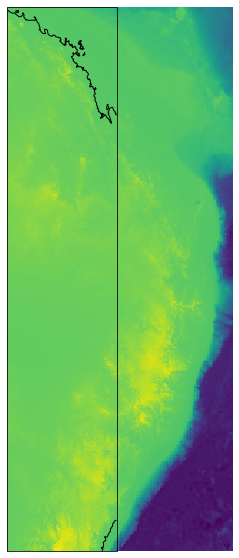

In [5]:
proj = ccrs.epsg(28355)


fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection=proj)
ax.imshow(z_grid, extent=extent_local, transform=proj)
ax.coastlines(resolution='10m')

In [6]:
np.savetxt("../Data/00_Elevation_5km.csv",
           np.c_[xq.ravel(),yq.ravel(),z_grid.ravel()],
           delimiter=',',
           fmt='%.3f',
           header='eastings,northings,RL')